<a href="https://colab.research.google.com/github/dctime/minecraft-texture-generation/blob/main/texture_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import shutil

  shutil.rmtree('images')
except:
  pass

import os
# create new single directory
os.mkdir('images')

In [2]:
import tensorflow as tf
try:
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))
except:
  print("no gpu")

Found GPU at: /device:GPU:0


In [3]:
import zipfile
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import os
np.set_printoptions(floatmode='fixed')
tf.config.run_functions_eagerly(True)
print(tf.__version__)
print("Eager execution:", tf.executing_eagerly())

2.12.0
Eager execution: True


In [4]:
with zipfile.ZipFile('drive/MyDrive/Minecraft Texture Generator/minecraft_texture_16.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [5]:
# for filename in os.listdir('dataset/minecraft_texture_with_resize_16'):
#     print(filename)

In [6]:
# ds = tf.keras.preprocessing.image_dataset_from_directory('/content/dataset', image_size=(16, 16), batch_size=1)
# train_dataset = tf.keras.utils.image_dataset_from_directory(
#     '/content/dataset',
#     batch_size=16,
#     image_size=(16, 16))
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/dataset',
    validation_split=0.05,
    subset='training',
    seed=400,
    image_size=(16, 16),
    batch_size=64,
    label_mode = None,
    color_mode = "rgba")

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/dataset',
    validation_split=0.05,
    subset='validation',
    seed=400,
    image_size=(16, 16),
    batch_size=64,
    label_mode = None,
    color_mode = "rgba")


print(train_dataset)
print(validation_dataset)

Found 32094 files belonging to 1 classes.
Using 30490 files for training.


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Found 32094 files belonging to 1 classes.
Using 1604 files for validation.
<_BatchDataset element_spec=TensorSpec(shape=(None, 16, 16, 4), dtype=tf.float32, name=None)>
<_BatchDataset element_spec=TensorSpec(shape=(None, 16, 16, 4), dtype=tf.float32, name=None)>


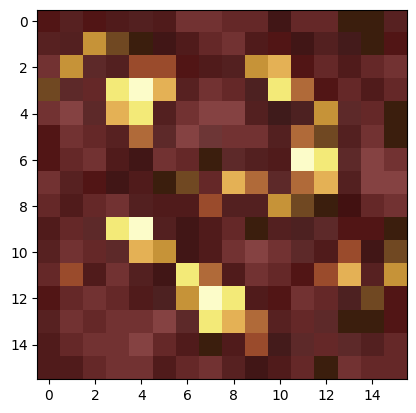

In [7]:
for images in train_dataset:
  image = images[0]
  plt.imshow(image.numpy().astype("uint8"))
  plt.show()
  break

In [8]:
def scale_img(img_ndarray):
  processing = img_ndarray
  return processing/255


train_dataset = train_dataset.map(scale_img)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=128)
train_dataset = train_dataset.prefetch(buffer_size=128)
print(train_dataset)


<_PrefetchDataset element_spec=TensorSpec(shape=(None, 16, 16, 4), dtype=tf.float32, name=None)>


In [9]:
def build_generator():
  model = Sequential()

  model.add(Dense((4*4*256), input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((4, 4, 256)))

  model.add(UpSampling2D())
  model.add(Conv2D(256, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(64, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(32, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(16, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(8, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(4, 5, padding='same', activation='sigmoid'))


  return model

In [10]:
build_generator().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              528384    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         1638656   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                        

In [11]:
def build_discriminator():
  # input 16x16x3
  model = Sequential()

  model.add(Conv2D(16, 5, padding='valid', input_shape = (16, 16, 4)))
  model.add(LeakyReLU(0.3))
  model.add(Dropout(0.4))

  model.add(Conv2D(32, 3, padding='valid'))
  model.add(LeakyReLU(0.3))
  model.add(Dropout(0.4))

  model.add(Conv2D(64, 3, padding='valid'))
  model.add(LeakyReLU(0.3))
  model.add(Dropout(0.4))

  model.add(Conv2D(128, 3, padding='valid'))
  model.add(LeakyReLU(0.3))
  model.add(Dropout(0.4))

  model.add(Conv2D(256, 2, padding='valid'))
  model.add(LeakyReLU(0.3))
  model.add(Dropout(0.4))

  model.add(Conv2D(512, 2, padding='valid'))
  model.add(LeakyReLU(0.3))
  model.add(Dropout(0.4))

  model.add(Conv2D(1024, 2, padding='valid'))
  model.add(LeakyReLU(0.3))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))



  return model

In [12]:
build_discriminator().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 12, 12, 16)        1616      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 12, 12, 16)        0         
                                                                 
 dropout (Dropout)           (None, 12, 12, 16)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 10, 32)        4640      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 10, 10, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 64)         

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              528384    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 8, 8, 256)        0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 8, 256)         1638656   
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 8, 8, 256)         0         
                                                      

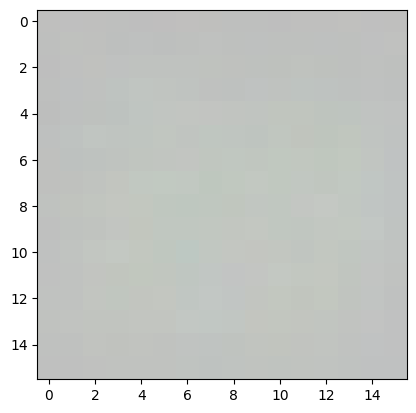

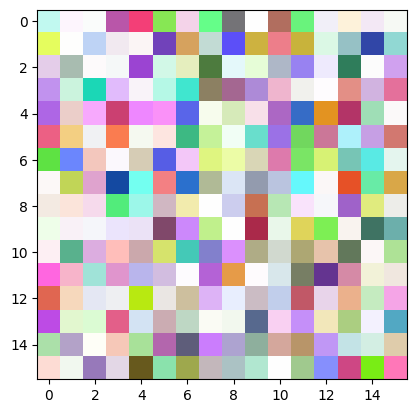

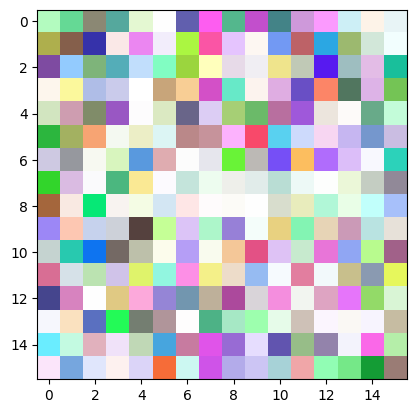

In [13]:
generator = build_generator()
generator.summary()
img = generator.predict(np.random.randn(3, 128, 1))
print(np.random.randn(3, 128, 1))
for index in range(0, 3):
  img = img*255
  plt.imshow(img[index].astype("uint8"))
  plt.show()

In [14]:
discriminator = build_discriminator()
discriminator.predict(tf.random.normal((16, 16, 16, 4)))

1/1 [==============================] - 0s 312ms/step


array([[0.49392995],
       [0.49155039],
       [0.50019264],
       [0.49113458],
       [0.49329096],
       [0.48733652],
       [0.49740806],
       [0.49691412],
       [0.50041360],
       [0.49729583],
       [0.49190769],
       [0.49381602],
       [0.49508715],
       [0.49898520],
       [0.48697647],
       [0.48911923]], dtype=float32)

In [15]:
discriminator.predict(train_dataset)

477/477 [==============================] - 10s 19ms/step


array([[0.49368939],
       [0.49870452],
       [0.49991062],
       ...,
       [0.49758852],
       [0.49768430],
       [0.49548924]], dtype=float32)

In [16]:
class MinecraftTextureGAN(Model):
  def __init__(self, generator, discriminator, batch_size, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.generator = generator
    self.discriminator = discriminator
    self.batch_size = batch_size

  def compile(self, g_loss, d_loss, g_optimizer, d_optimizer, *args, **kwargs):
    super().compile(*args, **kwargs)

    self.g_loss_f = g_loss
    self.d_loss_f = d_loss
    self.g_optimizer = g_optimizer
    self.d_optimizer = d_optimizer

    # self.g_optimizer.build(self.generator.trainable_variables)
    # self.d_optimizer.build(self.discriminator.trainable_variables)

  def train_step(self, batch_of_data):
    # train the discriminator
    with tf.GradientTape() as d_tape:
      real_img = batch_of_data
      # print(real_img.shape)

      # TODO: use this when the early is used
      self.batch_size = int(tf.shape(batch_of_data)[0].numpy())

      fake_img = generator(tf.random.normal((self.batch_size, 128, 1)), training=False)
      # print(fake_img.shape)

      real_and_fake_img = tf.concat([real_img, fake_img], axis=0)

      zeros = tf.zeros((self.batch_size, 1))
      random_arr = np.random.uniform(low=0.0, high=0.15, size=zeros.shape)
      zeros = zeros + random_arr

      ones = tf.ones((self.batch_size, 1))
      random_arr = np.random.uniform(low=0.0, high=0.15, size=ones.shape)
      ones = ones - random_arr

      real_and_fake_img_label = tf.concat([zeros, ones], axis=0)
      discriminator_prediction = self.discriminator(real_and_fake_img, training=True)
      # print(real_and_fake_img_label)
      # print(discriminator_prediction.shape)
      # print(real_and_fake_img_label.shape)
      real_and_fake_img_label = tf.squeeze(real_and_fake_img_label)
      discriminator_prediction = tf.squeeze(discriminator_prediction)

      d_loss = self.d_loss_f(real_and_fake_img_label, discriminator_prediction)
      # print(d_loss)

    d_gradient = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
    self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

    # train the generator
    with tf.GradientTape() as g_tape:
      generated_images = self.generator(tf.random.normal((self.batch_size, 128, 1)), training=True)

      trick_discriminator_prediction = self.discriminator(generated_images, training=False)
      generated_label = tf.ones((self.batch_size, 1))
      # print(trick_discriminator_prediction.shape)
      # print(generated_label.shape)

      generated_label = tf.squeeze(generated_label)
      trick_discriminator_prediction = tf.squeeze(trick_discriminator_prediction)
      g_loss = self.g_loss_f(generated_label, trick_discriminator_prediction)
      # print(g_loss)

    g_gradient = g_tape.gradient(g_loss, self.generator.trainable_variables)
    self.g_optimizer.apply_gradients(zip(g_gradient, self.generator.trainable_variables))

    return {'generator_loss': g_loss, 'discriminator_loss': d_loss}


In [17]:
class Monitor(Callback):
  def __init__(self, num_img, seed_dim):
    super().__init__()
    self.num_img = num_img
    self.seed_dim = seed_dim

  def on_epoch_end(self, epoch, logs=None):
    random_seed = tf.random.uniform((self.num_img, self.seed_dim, 1))
    generated_images = self.model.generator(random_seed)
    generated_images *= 255 # turn it back to normal images
    generated_images.numpy()
    for i in range(self.num_img): # loop from index 0 to num_img-1
      image = array_to_img(generated_images[i])
      image.save(os.path.join('images', f'generated_images_{epoch}_{i}.png'))


In [18]:
print(train_dataset)

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 16, 16, 4), dtype=tf.float32, name=None)>


In [ ]:
model = MinecraftTextureGAN(build_generator(), build_discriminator(), 64)
model.compile(BinaryCrossentropy(), BinaryCrossentropy(), Adam(learning_rate=0.0001), Adam(learning_rate=0.0001))
history = model.fit(x=train_dataset, epochs=50, callbacks=[Monitor(3, 128)])
# history = model.fit(train_dataset, epochs=50)

Epoch 1/50
234/477 [=============>................] - ETA: 47s - generator_loss: 0.1381 - discriminator_loss: 0.3396